UNIVERSIDAD NACIONAL DE SAN ANTONIO ABAD DEL CUSCO


```
# ESCUELA PROFESIONAL DE ING INFORMATICA Y DE SISTEMAS
# ASIGNATURA: MINERIA DE DATOS
# DOCENTE: MONTOYA CUBAS, CARLOS FERNANDO
# ESTUDIANTE: AYQUIPA GOMEZ, AMILCAR
# CODIGO: 131605
```



### **ALGORITMO APRIORI** 
---

Apriori fue uno de los primeros algoritmos desarrollados para la búsqueda de reglas de asociación y sigue siendo uno de los más empleados, pero al usar Apriori con un conjunto de datos más grande puede hacer que el proceso sea extremadamente lento, para esto es preferible realizar los siguientes pasos:

1. Identificar todos los itemsets que ocurren con una frecuencia por encima de un determinado límite de confianza y soporte (itemsets frecuentes).
2. Extraer todos los itemsets que tengan un valor de soporte superior a un umbreal minimo.
3. Seleccionar todas las mejores reglas de asociación de los subconjuntos con un valor de confianza superior al umbral mínimo.
4. Ordenar las reglas por orden descendente de lift y confidence.

Diagrama de flujo del algoritmo Apriori


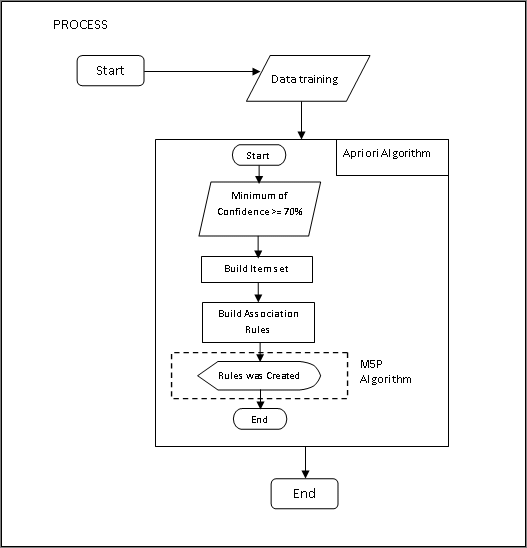

### **Importación de librerias necesarias**
---

In [ ]:
import pandas as pd
import numpy as np 
import collections # Libreria para el manejo de los diccionarios y tuplas
from collections import defaultdict

### **Implementación**
---
A continuación se muestra la implementación del algoritmo antes mencionado/descrito

In [ ]:
# Intersection: devuelve todos los conjuntos intersecados, 
# estos son el soporte de determinado itemset.
def intersection_s(set_s,playlist_s):
    playlists_inter = []
    for song in set_s: playlists_inter.append(playlist_s[song])
    return len(set.intersection(*playlists_inter))
    
# Genera combinaciones en los itemsets    
def combinations(it, r):
    aux = tuple(it)
    n = len(aux)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(aux[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i + 1, r):
            indices[j] = indices[j - 1] + 1
        yield tuple(aux[i] for i in indices)

In [ ]:
# Recibe la estructura de datos que contiene a las playlists y retorna una 
# estructura con los itemsets frecuentes bajo un umbral mínimo de soporte.

def get_frequent_itemsets(playlists, min_support):
  # Genera la frecuencia de cada cancion
  playlists = list(playlists.item().values())
  playlists = [set(playlist) for playlist in playlists]
  songes = [item for sublist in playlists for item in sublist]
  count_S = pd.Series(data=songes).value_counts().to_dict()

  # Generamos un diccionario de canciones y los indices respectivos 
  songs_pl = collections.defaultdict(set)
  for index, playlist in enumerate(playlists):
      for song in playlist:
          songs_pl[song].add(index)
  songs_pl = songs_pl
  count = {song: v for song, v in count_S.items() if v / len(playlists) >= min_support}
  itemset = [{song} for song in count.keys()]

  # Hallamos los itemsets mas frecuentes
  frecuency_itemsets = {}
  frecuency_itemsets[1] = sorted(count.items(), key=lambda x: x[1], reverse=True)
  frecuency_itemsets_size = []
  k = 2
  current = itemset
  while len(current) != 0:    
    # Generar itemsets 
    combinations = set() 
    m = k - 2
    for A in current: 
      A = list(A)
      for aux_A in current:
        aux_A = list(aux_A)
        u = True
        for i in range(k - 2):
          if A[i] != aux_A[i]:
              u = False
              break
        if not u:
          continue
        if A[k - 2] < aux_A[k - 2]:
          c = A + [aux_A[k - 2]]
          c = frozenset(sorted(c))
          combinations.add(c)

    # Verificacion del minimo de soporte para creacion de los itemsets.
    count_cb = {}   
    playlist_size = len(playlists)   
    for A in combinations:
        playlists_inter = []
        for song in A:
          playlists_inter.append(songs_pl[song])
        count_cb[A] = len(set.intersection(*playlists_inter))
    count2 = {subset: v for subset, v in count_cb.items() if v / playlist_size >= min_support} 
    dict2 = count2.keys() 
    frecuency_itemsets_size.extend(dict2)
    frecuency_itemsets[k] = sorted(count2.items(), key=lambda x: x[1], reverse=True)
    k += 1
    current = dict2

  sets = pd.DataFrame([item for sublist in frecuency_itemsets.values() for item in sublist]).round(3)
  sets.columns = ["itemset", "contador_support"]
  sets["support"] = sets["contador_support"] / len(playlists)

  output = []
  
  output.append(sets) # Itemsets.
  output.append(playlists)# Datos de la playlist.
  output.append(songs_pl)# canciones de la playlists.
  output.append(frecuency_itemsets_size) # Itemsets mas frecuentes.
  return output

In [ ]:
# Recibe los itemsets frecuentes generados por la función anterior y retorna las reglas de asociación. 
# Se le puede entregar umbrales de confianza o lift para las reglas que se retornarán.
def generate_association_rules(frequent_itemsets, confidence, lift):
  rules = []
  for itemset in frequent_itemsets[3]:
    #Todas las combinaciones posibles de X -> Y.
    count = intersection_s(itemset,frequent_itemsets[2])
    for i in range(1, len(itemset) + 1):
        for x in combinations(itemset, i):
            x = set(x)
            y = set(itemset) - x
            x1 = intersection_s(x,frequent_itemsets[2]) / len(frequent_itemsets[0])
            xy1 = intersection_s(x.union(y),frequent_itemsets[2]) / len(frequent_itemsets[0])
            confidence_rule = xy1 / x1
            if len(x) > 0 and len(y) > 0:
                y1 = intersection_s(y,frequent_itemsets[2]) / len(frequent_itemsets[0])
                rule_lift = xy1 / (x1 * y1)
                rules.append((x, y, confidence_rule, xy1, rule_lift))
  rulesd1 = pd.DataFrame(data=rules, columns=["X", "Y", "confidence", "support", "lift"]).round(3)
  rulesd1["X"] = list(map(tuple, rulesd1["X"]))
  rulesd1["Y"] = list(map(tuple, rulesd1["Y"]))

  #Reglas de asociacion de 10 elementos del confidence
  order_by = "confidence"
  n = 10
  confidence_df = rulesd1.sort_values(order_by, ascending=False).head(n)

  #Reglas de asociacion de 10 elementos del lift
  order_by = "lift"
  n = 10
  lift_df2 = rulesd1.sort_values(order_by, ascending=False).head(n)

  #Hallar las reglas de asociacion que cumplan con la condicion de confianza y lift
  rulesd1["len_itemset"] = rulesd1.apply(lambda x: len(set(x["X"]).union(set(x["Y"]))), axis=1)
  rulesd1=rulesd1.sort_values(by="len_itemset", ascending=False)
  both_rules = rulesd1[(rulesd1["confidence"] >= confidence) & (rulesd1["lift"] >= lift)]

  return confidence_df,lift_df2,both_rules

### **Carga y lectura de datos**
---

In [ ]:
db = np.load("spotify.npy", allow_pickle = True)

**1. Creamos itemsets con un umbral de soporte bajo (0.01).**

In [ ]:
itemsets = get_frequent_itemsets(db,0.01)

**2. Hallamos los 10 itemsets frecuentes con mayor soporte.**

In [ ]:
itemsets[0].sort_values(by="support").head(10)

,itemset,contador_support,support
1023,"(Bounce Back, Broccoli (feat. Lil Yachty), Bad...",100,0.01
999,"(goosebumps, Bank Account)",100,0.01
998,"(Swang, iSpy (feat. Lil Yachty))",100,0.01
997,"(One Dance, Jumpman)",100,0.01
996,"(Congratulations, No Problem (feat. Lil Wayne ...",100,0.01
995,"(No Problem (feat. Lil Wayne & 2 Chainz), Blac...",100,0.01
993,"(pick up the phone, Bad and Boujee (feat. Lil ...",100,0.01
828,Angels (feat. Saba),100,0.01
1000,"(Fake Love, Black Beatles)",100,0.01
829,Blasé (feat. Future & Rae Sremmurd),100,0.01


**3. Generar reglas de asociacion con una confianza de 0.5 y 1.2 de lift.**

In [ ]:
confidence_rules,lift_rules,both_rules = generate_association_rules(itemsets,0.5,1.2)

**4. Imprimimos las 10 reglas con mayor confidence**

In [ ]:
confidence_rules

,X,Y,confidence,support,lift
355,"(DNA., Mask Off)","(HUMBLE.,)",0.909,0.098,2.002
409,"(DNA., XO TOUR Llif3)","(HUMBLE.,)",0.864,0.100,1.904
38,"(DNA.,)","(HUMBLE.,)",0.823,0.186,1.811
349,"(Mask Off, XO TOUR Llif3)","(HUMBLE.,)",0.804,0.128,1.770
379,"(Broccoli (feat. Lil Yachty), Bounce Back)","(Bad and Boujee (feat. Lil Uzi Vert),)",0.775,0.098,2.301
373,"(Slippery (feat. Gucci Mane), XO TOUR Llif3)","(HUMBLE.,)",0.765,0.099,1.685
415,"(Tunnel Vision, XO TOUR Llif3)","(HUMBLE.,)",0.750,0.100,1.652
427,"(Congratulations, Mask Off)","(HUMBLE.,)",0.747,0.118,1.645
363,"(Mask Off, Bounce Back)","(HUMBLE.,)",0.743,0.099,1.635
385,"(Mask Off, goosebumps)","(HUMBLE.,)",0.743,0.107,1.637


**5. Imprimimos las 10 reglas ordenadas con mayor lift**

In [ ]:
lift_rules

,X,Y,confidence,support,lift
333,"(No Heart,)","(X (feat. Future),)",0.696,0.101,3.493
332,"(X (feat. Future),)","(No Heart,)",0.505,0.101,3.493
242,"(Chicken Fried,)","(Knee Deep (feat. Jimmy Buffett),)",0.500,0.104,3.261
243,"(Knee Deep (feat. Jimmy Buffett),)","(Chicken Fried,)",0.682,0.104,3.261
167,"(You Was Right,)","(Money Longer,)",0.603,0.114,3.183
166,"(Money Longer,)","(You Was Right,)",0.603,0.114,3.183
130,"(Butterfly Effect,)","(Bank Account,)",0.572,0.108,2.547
131,"(Bank Account,)","(Butterfly Effect,)",0.483,0.108,2.547
177,"(Bank Account,)","(Magnolia,)",0.491,0.110,2.541
176,"(Magnolia,)","(Bank Account,)",0.571,0.110,2.541


**6. Imprimimos las 10 reglas con la mayor confidence y lift.**

In [ ]:
both_rules.head(10)

,X,Y,confidence,support,lift,len_itemset
447,"(iSpy (feat. Lil Yachty), HUMBLE.)","(Mask Off,)",0.652,0.099,2.112,3
362,"(Bounce Back, HUMBLE.)","(Mask Off,)",0.647,0.099,2.098,3
368,"(Congratulations, Bad and Boujee (feat. Lil Uz...","(HUMBLE.,)",0.678,0.099,1.493,3
369,"(Bad and Boujee (feat. Lil Uzi Vert), HUMBLE.)","(Congratulations,)",0.605,0.099,1.537,3
373,"(Slippery (feat. Gucci Mane), XO TOUR Llif3)","(HUMBLE.,)",0.765,0.099,1.685,3
374,"(Slippery (feat. Gucci Mane), HUMBLE.)","(XO TOUR Llif3,)",0.682,0.099,2.164,3
379,"(Broccoli (feat. Lil Yachty), Bounce Back)","(Bad and Boujee (feat. Lil Uzi Vert),)",0.775,0.098,2.301,3
380,"(Bad and Boujee (feat. Lil Uzi Vert), Bounce B...","(Broccoli (feat. Lil Yachty),)",0.592,0.098,1.519,3
381,"(Broccoli (feat. Lil Yachty), Bad and Boujee (...","(Bounce Back,)",0.645,0.098,2.224,3
385,"(Mask Off, goosebumps)","(HUMBLE.,)",0.743,0.107,1.637,3


### **Obtener 4 reglas**
---

In [ ]:
Aux_4=both_rules.head(4)
Aux_4

,X,Y,confidence,support,lift,len_itemset
447,"(iSpy (feat. Lil Yachty), HUMBLE.)","(Mask Off,)",0.652,0.099,2.112,3
362,"(Bounce Back, HUMBLE.)","(Mask Off,)",0.647,0.099,2.098,3
368,"(Congratulations, Bad and Boujee (feat. Lil Uz...","(HUMBLE.,)",0.678,0.099,1.493,3
369,"(Bad and Boujee (feat. Lil Uzi Vert), HUMBLE.)","(Congratulations,)",0.605,0.099,1.537,3


### **Explicación de reglas obtenidas**
----

Para considerar sobre las 4 reglas obtenidas:
1.   Se puso un valor de umbral de soporte bajo (0.01) para que se pueda generar itemsets bastante discretos y faciles de analizar.
2.   El valor de lift indicara que la relacion de X e Y estan relacionados y de la misma forma con el support se tuvo en cuenta para poder relacionar las canciones y tener la mejor relacion posible.





###**Regla 1**
---
```
(iSpy (feat. Lil Yachty), HUMBLE.) -> (Mask Off,)	
```
Ambas canciones son de genero hip-hop/rap pero tambien pertenece al genero R&G, apesar de ello su relacion estada por mismo genero musical. Ademas, el valor de la confianza de la regla alcanza 0.652, el cual se considera baja aun siendo del mismo genero musical, entonces la relacion se podria decir que es alta.


### **Regla 2**
---
```
(Bounce Back, HUMBLE.) -> (Mask Off)	
```
La regla refleja que el valor de confianza respecto al anterior disminuyo ligeramente, 0.647, y al igual que la anterior pertenece al genero del hip-hop/rap teniendo un coeficiente de confianza bajo apesar de ser del mismo genero musical a pesar de no tener una dfiferencia en la epoca de lanzamiento transmiten diferentes estilos pero sigue siendo el mismo genro musical lo cual indica que la relacion estre las canciones es alta.

### **Regla 3**
---
```
(Congratulations, Bad and Boujee (feat. Lil Uz... -> 	(HUMBLE.,)
```
Podemos observar que el nivel de confianza es mas elevado a del resto, 0.678,  pero apesar de ello las relacion entre ellas sigue siendo buena y satisfactoria lo cual indica que es siendo pertenecientes al genero de hip-hop/rap y son relativamente cercanas respecto a la epoca de lanzamiento.

### **Regla 4**
---
```
(iSpy (feat. Lil Yachty), Congratulations)	(HUMBLE.,)	
```
Ambas canciones son recurentes ya que se mostraron en reglas anteriores lo cual indica que poseen una relacion elevada, puesto que tiene el nivel de confianza mas bajo 0.605, nos indica que las canciones apesar te tener tonos diferentes disfrutaras de las canciones relacionadas a estas.